Version 3-4a
BASELINE
autodl-A5000

调参lr

learning rate upper bound -> 2.66

fold0 2.60 0.8686
fold0 2.65 0.8696
fold0 2.66 0.8704
fold0 2.70 0.8695
fold0 2.75 0.8683
fold0 2.80 0.8674
fold0 3.00 0.8678
fold0 4.00 0.8656

v3-3
*   Fold0: 0.8678
*   Fold1: 0.8614
*   Fold2: 0.8628
*   Fold3: 0.8549
*   Fold4: 0.8649
*   CV: 0.8621
*   PB: 0.8402

now
*   Fold0: 0.8706
*   Fold1: 0.8624
*   Fold2: 0.8631
*   Fold3: 0.8580
*   Fold4: 0.8632
*   CV: 0.8634
*   PB: 0.8382











## 3 Config

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
import os

version = 'v3-4a'
INPUT_DIR = 'us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = 'autodl-tmp/' + version + '/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [ ]:
class CFG:
    wandb=False
    #competition='PPPM'
    #_wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=456 #10%
    epochs=5
    encoder_lr=2.66e-5
    decoder_lr=2.66e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=1995
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

## 4 Data Process

In [ ]:
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.10.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.2
env: TOKENIZERS_PARALLELISM=true


In [ ]:
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [ ]:
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [ ]:
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s) #['A\t\tHUMAN NECESSITIES']
        cpc_result = result[0].lstrip(pattern) #HUMAN NECESSITIES
        for context in [c for c in contexts if c[0] == cpc]: # 'A01', 'A21', 'A22', 'A23'
          pattern = f'{context}\t\t.+'
          result = re.findall(pattern, s)
          result1=''
          for sub_context in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
            pattern0 = f'{context}{sub_context}\t\t.+'
            result0 = re.findall(pattern0, s)
            if result0:
              result0=result0[0].lstrip(pattern0)
              result0=re.sub(u'\(.*?\)','',result0)
              # result0=re.sub(u'\(.*?\]','',result0)
              result1=result1+". "+result0
          results[context] = cpc_result + ". " + result[0].lstrip(pattern)+result1
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [ ]:
def handle(x):
  return x.replace(' .', '.').replace(' ;', ';').rstrip()

In [ ]:
train['context_text']=train['context_text'].apply(handle)

In [ ]:
train.loc[196,'context_text']

In [ ]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

In [ ]:
test.loc[1].text

'adjust gas flow[SEP]altering gas flow[SEP]MECHANICAL ENGINEERING; LIGHTING; HEATING; WEAPONS; BLASTING. COMBUSTION APPARATUS; COMBUSTION PROCESSES'

<AxesSubplot:>

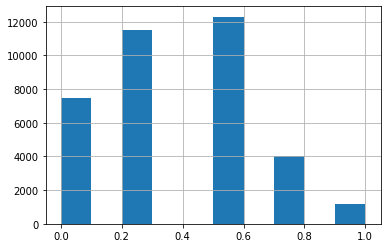

In [ ]:
train['score'].hist()

In [ ]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

In [ ]:
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    7295
1    7295
2    7295
3    7294
4    7294
dtype: int64

In [ ]:
train.to_csv(OUTPUT_DIR + 'train_fold5.csv', index = False)

## 5 Model

In [ ]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

In [ ]:
CFG.model

'microsoft/deberta-v3-large'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [ ]:
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.layer_norm1 = nn.LayerNorm(self.config.hidden_size)
        self._init_weights(self.attention)
        self.linear = nn.Linear(self.config.hidden_size, 1)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_state = outputs[0]
        input_mask_expanded = inputs["attention_mask"].unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        out = sum_embeddings / sum_mask
        
        out = self.layer_norm1(out)
        output = self.fc(out)
        
        
        return output

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

## 6 Training

In [ ]:
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    print("num_train_steps: ", num_train_steps)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

num_train_steps:  4559
Epoch: [1][0/911] Elapsed 0m 1s (remain 23m 16s) Loss: 0.6771(0.6771) Grad: inf  LR: 0.00000006  
Epoch: [1][100/911] Elapsed 0m 44s (remain 5m 54s) Loss: 0.6333(0.6541) Grad: 20604.9297  LR: 0.00000589  
Epoch: [1][200/911] Elapsed 1m 27s (remain 5m 8s) Loss: 0.5637(0.6290) Grad: 8809.6299  LR: 0.00001172  
Epoch: [1][300/911] Elapsed 2m 10s (remain 4m 24s) Loss: 0.5824(0.6131) Grad: 15955.8682  LR: 0.00001756  
Epoch: [1][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.5425(0.5996) Grad: 16946.4375  LR: 0.00002339  
Epoch: [1][500/911] Elapsed 3m 36s (remain 2m 56s) Loss: 0.5960(0.5914) Grad: 19515.0469  LR: 0.00002659  
Epoch: [1][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.5331(0.5848) Grad: 13708.3193  LR: 0.00002652  
Epoch: [1][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.5975(0.5802) Grad: 16666.7520  LR: 0.00002637  
Epoch: [1][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.6020(0.5758) Grad: 10193.8936  LR: 0.00002614  
Epoch: [1][900/911] Elapse

Epoch 1 - avg_train_loss: 0.5726  avg_val_loss: 0.5383  time: 434s
Epoch 1 - Score: 0.8304
Epoch 1 - Save Best Score: 0.8304 Model


Epoch: [2][0/911] Elapsed 0m 1s (remain 16m 9s) Loss: 0.4781(0.4781) Grad: 73216.2578  LR: 0.00002580  
Epoch: [2][100/911] Elapsed 0m 44s (remain 5m 54s) Loss: 0.4940(0.5314) Grad: 32068.6387  LR: 0.00002541  
Epoch: [2][200/911] Elapsed 1m 27s (remain 5m 7s) Loss: 0.4802(0.5261) Grad: 28764.0703  LR: 0.00002496  
Epoch: [2][300/911] Elapsed 2m 10s (remain 4m 23s) Loss: 0.5525(0.5256) Grad: 42536.3750  LR: 0.00002443  
Epoch: [2][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.4938(0.5241) Grad: 24262.9141  LR: 0.00002384  
Epoch: [2][500/911] Elapsed 3m 36s (remain 2m 56s) Loss: 0.5216(0.5219) Grad: 47443.8125  LR: 0.00002319  
Epoch: [2][600/911] Elapsed 4m 18s (remain 2m 13s) Loss: 0.4987(0.5211) Grad: 97885.5547  LR: 0.00002248  
Epoch: [2][700/911] Elapsed 5m 1s (remain 1m 30s) Loss: 0.6372(0.5223) Grad: 67092.8750  LR: 0.00002172  
Epoch: [2][800/911] Elapsed 5m 44s (remain 0m 47s) Loss: 0.5665(0.5222) Grad: 88058.0312  LR: 0.00002091  
Epoch: [2][900/911] Elapsed 6m 27s (remain

Epoch 2 - avg_train_loss: 0.5221  avg_val_loss: 0.5322  time: 433s
Epoch 2 - Score: 0.8610
Epoch 2 - Save Best Score: 0.8610 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.5080(0.5322) 
Epoch: [3][0/911] Elapsed 0m 1s (remain 15m 35s) Loss: 0.5227(0.5227) Grad: 80003.1719  LR: 0.00001996  
Epoch: [3][100/911] Elapsed 0m 44s (remain 5m 54s) Loss: 0.5001(0.5076) Grad: 39607.9492  LR: 0.00001906  
Epoch: [3][200/911] Elapsed 1m 27s (remain 5m 7s) Loss: 0.4459(0.5054) Grad: 49204.5039  LR: 0.00001812  
Epoch: [3][300/911] Elapsed 2m 10s (remain 4m 23s) Loss: 0.4443(0.5067) Grad: 28566.2363  LR: 0.00001716  
Epoch: [3][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.5747(0.5084) Grad: 66671.1094  LR: 0.00001617  
Epoch: [3][500/911] Elapsed 3m 36s (remain 2m 56s) Loss: 0.5400(0.5084) Grad: 51648.0000  LR: 0.00001517  
Epoch: [3][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.4380(0.5081) Grad: 23583.3008  LR: 0.00001416  
Epoch: [3][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.4978(0.5073) Grad: 18516.0195  LR: 0.00001314  
Epoch: [3][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.5253(0.5080) Grad: 44

Epoch 3 - avg_train_loss: 0.5082  avg_val_loss: 0.5319  time: 433s
Epoch 3 - Score: 0.8677
Epoch 3 - Save Best Score: 0.8677 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4925(0.5319) 
Epoch: [4][0/911] Elapsed 0m 1s (remain 17m 22s) Loss: 0.4754(0.4754) Grad: 47606.5000  LR: 0.00001100  
Epoch: [4][100/911] Elapsed 0m 44s (remain 5m 55s) Loss: 0.5187(0.5061) Grad: 48269.0938  LR: 0.00001001  
Epoch: [4][200/911] Elapsed 1m 27s (remain 5m 7s) Loss: 0.5084(0.5038) Grad: 188435.2969  LR: 0.00000903  
Epoch: [4][300/911] Elapsed 2m 10s (remain 4m 23s) Loss: 0.4931(0.5049) Grad: 47432.5547  LR: 0.00000808  
Epoch: [4][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.4995(0.5022) Grad: 51710.4141  LR: 0.00000716  
Epoch: [4][500/911] Elapsed 3m 36s (remain 2m 56s) Loss: 0.5621(0.5027) Grad: 55558.6094  LR: 0.00000628  
Epoch: [4][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.5715(0.5025) Grad: 43157.2109  LR: 0.00000543  
Epoch: [4][700/911] Elapsed 5m 1s (remain 1m 30s) Loss: 0.5495(0.5010) Grad: 33617.5586  LR: 0.00000464  
Epoch: [4][800/911] Elapsed 5m 44s (remain 0m 47s) Loss: 0.4444(0.4999) Grad: 1

Epoch 4 - avg_train_loss: 0.4993  avg_val_loss: 0.5337  time: 433s
Epoch 4 - Score: 0.8701
Epoch 4 - Save Best Score: 0.8701 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4923(0.5337) 
Epoch: [5][0/911] Elapsed 0m 1s (remain 16m 27s) Loss: 0.5019(0.5019) Grad: 87570.1875  LR: 0.00000313  
Epoch: [5][100/911] Elapsed 0m 44s (remain 5m 54s) Loss: 0.3881(0.4902) Grad: 36915.1172  LR: 0.00000250  
Epoch: [5][200/911] Elapsed 1m 27s (remain 5m 8s) Loss: 0.5307(0.4885) Grad: 56139.6758  LR: 0.00000194  
Epoch: [5][300/911] Elapsed 2m 10s (remain 4m 23s) Loss: 0.3568(0.4935) Grad: 47360.9258  LR: 0.00000144  
Epoch: [5][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.4144(0.4959) Grad: 44223.3047  LR: 0.00000102  
Epoch: [5][500/911] Elapsed 3m 35s (remain 2m 56s) Loss: 0.4173(0.4963) Grad: 295081.5312  LR: 0.00000066  
Epoch: [5][600/911] Elapsed 4m 18s (remain 2m 13s) Loss: 0.5915(0.4963) Grad: 30590.8008  LR: 0.00000038  
Epoch: [5][700/911] Elapsed 5m 1s (remain 1m 30s) Loss: 0.6273(0.4969) Grad: 294550.5938  LR: 0.00000018  
Epoch: [5][800/911] Elapsed 5m 44s (remain 0m 47s) Loss: 0.4688(0.4958) Grad: 

Epoch 5 - avg_train_loss: 0.4954  avg_val_loss: 0.5348  time: 433s
Epoch 5 - Score: 0.8706
Epoch 5 - Save Best Score: 0.8706 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4927(0.5348) 


========== fold: 0 result ==========
Score: 0.8706
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

num_train_steps:  4559
Epoch: [1][0/911] Elapsed 0m 1s (remain 16m 22s) Loss: 0.6808(0.6808) Grad: inf  LR: 0.00000006  
Epoch: [1][100/911] Elapsed 0m 43s (remain 5m 52s) Loss: 0.6250(0.6492) Grad: 24772.0996  LR: 0.00000589  
Epoch: [1][200/911] Elapsed 1m 26s (remain 5m 6s) Loss: 0.5912(0.6248) Grad: 11739.8008  LR: 0.00001172  
Epoch: [1][300/911] Elapsed 2m 9s (remain 4m 22s) Loss: 0.5802(0.6103) Grad: 13470.9736  LR: 0.00001756  
Epoch: [1][400/911] Elapsed 2m 52s (remain 3m 39s) Loss: 0.6200(0.5984) Grad: 27683.3320  LR: 0.00002339  
Epoch: [1][500/911] Elapsed 3m 35s (remain 2m 56s) Loss: 0.5252(0.5890) Grad: 17806.4785  LR: 0.00002659  
Epoch: [1][600/911] Elapsed 4m 18s (remain 2m 13s) Loss: 0.5739(0.5838) Grad: 10472.1084  LR: 0.00002652  
Epoch: [1][700/911] Elapsed 5m 1s (remain 1m 30s) Loss: 0.5126(0.5795) Grad: 7331.2998  LR: 0.00002637  
Epoch: [1][800/911] Elapsed 5m 44s (remain 0m 47s) Loss: 0.5031(0.5762) Grad: 22823.5898  LR: 0.00002614  
Epoch: [1][900/911] Elapsed

Epoch 1 - avg_train_loss: 0.5726  avg_val_loss: 0.5446  time: 433s
Epoch 1 - Score: 0.8220
Epoch 1 - Save Best Score: 0.8220 Model


Epoch: [2][0/911] Elapsed 0m 1s (remain 15m 30s) Loss: 0.5894(0.5894) Grad: 142161.2031  LR: 0.00002580  
Epoch: [2][100/911] Elapsed 0m 43s (remain 5m 52s) Loss: 0.4750(0.5254) Grad: 101955.1875  LR: 0.00002541  
Epoch: [2][200/911] Elapsed 1m 26s (remain 5m 6s) Loss: 0.4253(0.5242) Grad: 52825.7969  LR: 0.00002496  
Epoch: [2][300/911] Elapsed 2m 9s (remain 4m 23s) Loss: 0.5567(0.5255) Grad: 107658.0781  LR: 0.00002443  
Epoch: [2][400/911] Elapsed 2m 52s (remain 3m 39s) Loss: 0.5037(0.5232) Grad: 84369.0391  LR: 0.00002384  
Epoch: [2][500/911] Elapsed 3m 35s (remain 2m 56s) Loss: 0.4409(0.5217) Grad: 47469.0000  LR: 0.00002319  
Epoch: [2][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.4915(0.5209) Grad: 29477.2480  LR: 0.00002248  
Epoch: [2][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.5518(0.5211) Grad: 20691.3555  LR: 0.00002172  
Epoch: [2][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.4753(0.5212) Grad: 44055.9844  LR: 0.00002091  
Epoch: [2][900/911] Elapsed 6m 28s (rem

Epoch 2 - avg_train_loss: 0.5214  avg_val_loss: 0.5366  time: 434s
Epoch 2 - Score: 0.8533
Epoch 2 - Save Best Score: 0.8533 Model


Epoch: [3][0/911] Elapsed 0m 1s (remain 17m 19s) Loss: 0.5124(0.5124) Grad: 49191.2070  LR: 0.00001996  
Epoch: [3][100/911] Elapsed 0m 44s (remain 5m 55s) Loss: 0.5343(0.5056) Grad: 22920.4355  LR: 0.00001906  
Epoch: [3][200/911] Elapsed 1m 27s (remain 5m 8s) Loss: 0.5025(0.5043) Grad: 54990.5820  LR: 0.00001812  
Epoch: [3][300/911] Elapsed 2m 10s (remain 4m 24s) Loss: 0.5526(0.5038) Grad: 36054.5195  LR: 0.00001716  
Epoch: [3][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.4890(0.5064) Grad: 45021.2852  LR: 0.00001617  
Epoch: [3][500/911] Elapsed 3m 36s (remain 2m 57s) Loss: 0.4684(0.5075) Grad: 75128.2422  LR: 0.00001517  
Epoch: [3][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.5372(0.5080) Grad: 70842.9609  LR: 0.00001416  
Epoch: [3][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.4939(0.5069) Grad: 61080.2461  LR: 0.00001314  
Epoch: [3][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.5254(0.5078) Grad: 77506.3281  LR: 0.00001213  
Epoch: [3][900/911] Elapsed 6m 28s (remai

Epoch 3 - avg_train_loss: 0.5081  avg_val_loss: 0.5335  time: 434s
Epoch 3 - Score: 0.8622
Epoch 3 - Save Best Score: 0.8622 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4421(0.5335) 
Epoch: [4][0/911] Elapsed 0m 1s (remain 16m 1s) Loss: 0.4721(0.4721) Grad: 48243.2891  LR: 0.00001100  
Epoch: [4][100/911] Elapsed 0m 44s (remain 5m 53s) Loss: 0.5602(0.4967) Grad: 53538.8242  LR: 0.00001001  
Epoch: [4][200/911] Elapsed 1m 27s (remain 5m 8s) Loss: 0.5840(0.5027) Grad: 274379.0625  LR: 0.00000903  
Epoch: [4][300/911] Elapsed 2m 10s (remain 4m 24s) Loss: 0.5189(0.5022) Grad: 134321.2812  LR: 0.00000808  
Epoch: [4][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.4327(0.5045) Grad: 18752.5781  LR: 0.00000716  
Epoch: [4][500/911] Elapsed 3m 36s (remain 2m 57s) Loss: 0.4515(0.5043) Grad: 148927.7812  LR: 0.00000628  
Epoch: [4][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.5104(0.5044) Grad: 47841.8398  LR: 0.00000543  
Epoch: [4][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.5436(0.5034) Grad: 33195.0352  LR: 0.00000464  
Epoch: [4][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.4852(0.5023) Grad: 

Epoch 4 - avg_train_loss: 0.5010  avg_val_loss: 0.5392  time: 434s
Epoch 4 - Score: 0.8626
Epoch 4 - Save Best Score: 0.8626 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4476(0.5392) 
Epoch: [5][0/911] Elapsed 0m 1s (remain 16m 21s) Loss: 0.4315(0.4315) Grad: 81326.2969  LR: 0.00000313  
Epoch: [5][100/911] Elapsed 0m 44s (remain 5m 54s) Loss: 0.4467(0.4914) Grad: 31793.9238  LR: 0.00000250  
Epoch: [5][200/911] Elapsed 1m 27s (remain 5m 8s) Loss: 0.5255(0.4933) Grad: 36965.0742  LR: 0.00000194  
Epoch: [5][300/911] Elapsed 2m 10s (remain 4m 24s) Loss: 0.5199(0.4945) Grad: 37924.7383  LR: 0.00000144  
Epoch: [5][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.5636(0.4962) Grad: 115352.9453  LR: 0.00000102  
Epoch: [5][500/911] Elapsed 3m 36s (remain 2m 57s) Loss: 0.4843(0.4959) Grad: 35956.3945  LR: 0.00000066  
Epoch: [5][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.4808(0.4959) Grad: 95895.9844  LR: 0.00000038  
Epoch: [5][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.4943(0.4959) Grad: 43949.3203  LR: 0.00000018  
Epoch: [5][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.4899(0.4965) Grad: 4

Epoch 5 - avg_train_loss: 0.4972  avg_val_loss: 0.5408  time: 434s
Epoch 5 - Score: 0.8624


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4452(0.5408) 


========== fold: 1 result ==========
Score: 0.8626
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

num_train_steps:  4559
Epoch: [1][0/911] Elapsed 0m 1s (remain 16m 31s) Loss: 0.7438(0.7438) Grad: inf  LR: 0.00000006  
Epoch: [1][100/911] Elapsed 0m 43s (remain 5m 52s) Loss: 0.6350(0.6582) Grad: 19908.5000  LR: 0.00000589  
Epoch: [1][200/911] Elapsed 1m 26s (remain 5m 6s) Loss: 0.5804(0.6286) Grad: 15055.6367  LR: 0.00001172  
Epoch: [1][300/911] Elapsed 2m 9s (remain 4m 22s) Loss: 0.5407(0.6101) Grad: 9420.0732  LR: 0.00001756  
Epoch: [1][400/911] Elapsed 2m 52s (remain 3m 39s) Loss: 0.5775(0.5974) Grad: 24573.4199  LR: 0.00002339  
Epoch: [1][500/911] Elapsed 3m 35s (remain 2m 56s) Loss: 0.5346(0.5886) Grad: 13668.1348  LR: 0.00002659  
Epoch: [1][600/911] Elapsed 4m 18s (remain 2m 13s) Loss: 0.6369(0.5824) Grad: 38506.7852  LR: 0.00002652  
Epoch: [1][700/911] Elapsed 5m 1s (remain 1m 30s) Loss: 0.5534(0.5780) Grad: 19808.6211  LR: 0.00002637  
Epoch: [1][800/911] Elapsed 5m 44s (remain 0m 47s) Loss: 0.5661(0.5739) Grad: 18593.1074  LR: 0.00002614  
Epoch: [1][900/911] Elapsed

Epoch 1 - avg_train_loss: 0.5703  avg_val_loss: 0.5459  time: 433s
Epoch 1 - Score: 0.8267
Epoch 1 - Save Best Score: 0.8267 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4714(0.5459) 
Epoch: [2][0/911] Elapsed 0m 1s (remain 15m 36s) Loss: 0.4078(0.4078) Grad: 66515.6172  LR: 0.00002580  
Epoch: [2][100/911] Elapsed 0m 44s (remain 5m 54s) Loss: 0.5686(0.5297) Grad: 24918.8516  LR: 0.00002541  
Epoch: [2][200/911] Elapsed 1m 27s (remain 5m 8s) Loss: 0.4872(0.5242) Grad: 18569.5938  LR: 0.00002496  
Epoch: [2][300/911] Elapsed 2m 10s (remain 4m 24s) Loss: 0.5091(0.5228) Grad: 15439.0049  LR: 0.00002443  
Epoch: [2][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.5801(0.5221) Grad: 30384.4082  LR: 0.00002384  
Epoch: [2][500/911] Elapsed 3m 36s (remain 2m 57s) Loss: 0.5140(0.5232) Grad: 90037.1250  LR: 0.00002319  
Epoch: [2][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.5603(0.5224) Grad: 98784.5234  LR: 0.00002248  
Epoch: [2][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.6068(0.5226) Grad: 18507.9180  LR: 0.00002172  
Epoch: [2][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.4998(0.5224) Grad: 33

Epoch 2 - avg_train_loss: 0.5221  avg_val_loss: 0.5305  time: 434s
Epoch 2 - Score: 0.8570
Epoch 2 - Save Best Score: 0.8570 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4602(0.5305) 
Epoch: [3][0/911] Elapsed 0m 1s (remain 16m 36s) Loss: 0.5198(0.5198) Grad: 55195.0547  LR: 0.00001996  
Epoch: [3][100/911] Elapsed 0m 44s (remain 5m 53s) Loss: 0.5370(0.5111) Grad: 70524.0078  LR: 0.00001906  
Epoch: [3][200/911] Elapsed 1m 26s (remain 5m 7s) Loss: 0.5588(0.5095) Grad: 68990.7266  LR: 0.00001812  
Epoch: [3][300/911] Elapsed 2m 10s (remain 4m 23s) Loss: 0.4536(0.5072) Grad: 90325.0391  LR: 0.00001716  
Epoch: [3][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.5747(0.5074) Grad: 117514.0078  LR: 0.00001617  
Epoch: [3][500/911] Elapsed 3m 36s (remain 2m 56s) Loss: 0.5106(0.5081) Grad: 47736.3438  LR: 0.00001517  
Epoch: [3][600/911] Elapsed 4m 18s (remain 2m 13s) Loss: 0.5545(0.5069) Grad: 80665.2500  LR: 0.00001416  
Epoch: [3][700/911] Elapsed 5m 1s (remain 1m 30s) Loss: 0.5135(0.5073) Grad: 66262.3828  LR: 0.00001314  
Epoch: [3][800/911] Elapsed 5m 44s (remain 0m 47s) Loss: 0.5230(0.5078) Grad: 7

Epoch 3 - avg_train_loss: 0.5061  avg_val_loss: 0.5333  time: 433s
Epoch 3 - Score: 0.8612
Epoch 3 - Save Best Score: 0.8612 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4857(0.5333) 
Epoch: [4][0/911] Elapsed 0m 1s (remain 16m 34s) Loss: 0.5535(0.5535) Grad: 53121.3047  LR: 0.00001100  
Epoch: [4][100/911] Elapsed 0m 44s (remain 5m 55s) Loss: 0.5493(0.4976) Grad: 51581.3594  LR: 0.00001001  
Epoch: [4][200/911] Elapsed 1m 27s (remain 5m 9s) Loss: 0.4571(0.4969) Grad: 41047.0430  LR: 0.00000903  
Epoch: [4][300/911] Elapsed 2m 10s (remain 4m 25s) Loss: 0.5019(0.4967) Grad: 81314.3828  LR: 0.00000808  
Epoch: [4][400/911] Elapsed 2m 53s (remain 3m 41s) Loss: 0.4191(0.4984) Grad: 51800.2891  LR: 0.00000716  
Epoch: [4][500/911] Elapsed 3m 36s (remain 2m 57s) Loss: 0.5508(0.4990) Grad: 153688.3438  LR: 0.00000628  
Epoch: [4][600/911] Elapsed 4m 19s (remain 2m 14s) Loss: 0.5406(0.5007) Grad: 26228.8809  LR: 0.00000543  
Epoch: [4][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.4701(0.5005) Grad: 66782.9609  LR: 0.00000464  
Epoch: [4][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.5131(0.5003) Grad: 2

Epoch 4 - avg_train_loss: 0.4995  avg_val_loss: 0.5368  time: 434s
Epoch 4 - Score: 0.8631
Epoch 4 - Save Best Score: 0.8631 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4888(0.5368) 
Epoch: [5][0/911] Elapsed 0m 1s (remain 15m 17s) Loss: 0.5278(0.5278) Grad: 27074.0879  LR: 0.00000313  
Epoch: [5][100/911] Elapsed 0m 44s (remain 5m 54s) Loss: 0.4978(0.4940) Grad: 82648.8125  LR: 0.00000250  
Epoch: [5][200/911] Elapsed 1m 27s (remain 5m 8s) Loss: 0.5283(0.4958) Grad: 130347.1953  LR: 0.00000194  
Epoch: [5][300/911] Elapsed 2m 10s (remain 4m 24s) Loss: 0.4444(0.4953) Grad: 30928.7617  LR: 0.00000144  
Epoch: [5][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.4341(0.4976) Grad: 33897.6406  LR: 0.00000102  
Epoch: [5][500/911] Elapsed 3m 36s (remain 2m 57s) Loss: 0.4584(0.4969) Grad: 65070.3750  LR: 0.00000066  
Epoch: [5][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.5405(0.4975) Grad: 127620.0859  LR: 0.00000038  
Epoch: [5][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.5333(0.4955) Grad: 342253.9688  LR: 0.00000018  
Epoch: [5][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.4454(0.4964) Grad:

Epoch 5 - avg_train_loss: 0.4965  avg_val_loss: 0.5386  time: 434s
Epoch 5 - Score: 0.8621
========== fold: 2 result ==========
Score: 0.8631
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from th

num_train_steps:  4559
Epoch: [1][0/911] Elapsed 0m 1s (remain 24m 44s) Loss: 0.8386(0.8386) Grad: inf  LR: 0.00000006  
Epoch: [1][100/911] Elapsed 0m 44s (remain 5m 59s) Loss: 0.6251(0.6742) Grad: 23472.0430  LR: 0.00000589  
Epoch: [1][200/911] Elapsed 1m 27s (remain 5m 10s) Loss: 0.6403(0.6352) Grad: 23676.0586  LR: 0.00001172  
Epoch: [1][300/911] Elapsed 2m 11s (remain 4m 25s) Loss: 0.5269(0.6123) Grad: 25469.4473  LR: 0.00001756  
Epoch: [1][400/911] Elapsed 2m 54s (remain 3m 41s) Loss: 0.5607(0.6013) Grad: 10537.9023  LR: 0.00002339  
Epoch: [1][500/911] Elapsed 3m 37s (remain 2m 57s) Loss: 0.5641(0.5933) Grad: 9033.8936  LR: 0.00002659  
Epoch: [1][600/911] Elapsed 4m 20s (remain 2m 14s) Loss: 0.6055(0.5858) Grad: 11078.2393  LR: 0.00002652  
Epoch: [1][700/911] Elapsed 5m 3s (remain 1m 30s) Loss: 0.5296(0.5798) Grad: 10158.4180  LR: 0.00002637  
Epoch: [1][800/911] Elapsed 5m 46s (remain 0m 47s) Loss: 0.4724(0.5764) Grad: 8906.6572  LR: 0.00002614  
Epoch: [1][900/911] Elapse

Epoch 1 - avg_train_loss: 0.5729  avg_val_loss: 0.5453  time: 435s
Epoch 1 - Score: 0.8176
Epoch 1 - Save Best Score: 0.8176 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.5055(0.5453) 
Epoch: [2][0/911] Elapsed 0m 1s (remain 16m 36s) Loss: 0.5446(0.5446) Grad: 55827.1719  LR: 0.00002580  
Epoch: [2][100/911] Elapsed 0m 44s (remain 5m 53s) Loss: 0.5389(0.5312) Grad: 105457.6016  LR: 0.00002541  
Epoch: [2][200/911] Elapsed 1m 27s (remain 5m 7s) Loss: 0.4908(0.5319) Grad: 79405.7734  LR: 0.00002496  
Epoch: [2][300/911] Elapsed 2m 10s (remain 4m 24s) Loss: 0.4791(0.5285) Grad: 103202.4375  LR: 0.00002443  
Epoch: [2][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.4556(0.5271) Grad: 111745.5469  LR: 0.00002384  
Epoch: [2][500/911] Elapsed 3m 36s (remain 2m 57s) Loss: 0.5980(0.5253) Grad: 33912.6641  LR: 0.00002319  
Epoch: [2][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.6082(0.5232) Grad: 452900.7500  LR: 0.00002248  
Epoch: [2][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.4931(0.5220) Grad: 33175.0508  LR: 0.00002172  
Epoch: [2][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.6416(0.5217) Grad

Epoch 2 - avg_train_loss: 0.5215  avg_val_loss: 0.5367  time: 434s
Epoch 2 - Score: 0.8466
Epoch 2 - Save Best Score: 0.8466 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4945(0.5367) 
Epoch: [3][0/911] Elapsed 0m 1s (remain 15m 16s) Loss: 0.5430(0.5430) Grad: 52155.2969  LR: 0.00001996  
Epoch: [3][100/911] Elapsed 0m 44s (remain 5m 53s) Loss: 0.4845(0.5164) Grad: 54416.9180  LR: 0.00001906  
Epoch: [3][200/911] Elapsed 1m 27s (remain 5m 7s) Loss: 0.5205(0.5174) Grad: 77122.2578  LR: 0.00001812  
Epoch: [3][300/911] Elapsed 2m 9s (remain 4m 23s) Loss: 0.4647(0.5133) Grad: 39017.0508  LR: 0.00001716  
Epoch: [3][400/911] Elapsed 2m 52s (remain 3m 39s) Loss: 0.4332(0.5117) Grad: 76327.7188  LR: 0.00001617  
Epoch: [3][500/911] Elapsed 3m 35s (remain 2m 56s) Loss: 0.4747(0.5117) Grad: 161610.3281  LR: 0.00001517  
Epoch: [3][600/911] Elapsed 4m 18s (remain 2m 13s) Loss: 0.5487(0.5104) Grad: 84263.5547  LR: 0.00001416  
Epoch: [3][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.4662(0.5098) Grad: 20553.4707  LR: 0.00001314  
Epoch: [3][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.5568(0.5087) Grad: 91

Epoch 3 - avg_train_loss: 0.5090  avg_val_loss: 0.5378  time: 434s
Epoch 3 - Score: 0.8558
Epoch 3 - Save Best Score: 0.8558 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4817(0.5378) 
Epoch: [4][0/911] Elapsed 0m 1s (remain 16m 30s) Loss: 0.4837(0.4837) Grad: 144052.3438  LR: 0.00001100  
Epoch: [4][100/911] Elapsed 0m 44s (remain 5m 53s) Loss: 0.4936(0.5002) Grad: 43564.9336  LR: 0.00001001  
Epoch: [4][200/911] Elapsed 1m 27s (remain 5m 7s) Loss: 0.4335(0.4998) Grad: 46146.0625  LR: 0.00000903  
Epoch: [4][300/911] Elapsed 2m 10s (remain 4m 23s) Loss: 0.5451(0.4998) Grad: 74963.7031  LR: 0.00000808  
Epoch: [4][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.5431(0.5009) Grad: 54007.4414  LR: 0.00000716  
Epoch: [4][500/911] Elapsed 3m 36s (remain 2m 56s) Loss: 0.5278(0.5007) Grad: 28365.8965  LR: 0.00000628  
Epoch: [4][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.4716(0.5022) Grad: 102820.3203  LR: 0.00000543  
Epoch: [4][700/911] Elapsed 5m 1s (remain 1m 30s) Loss: 0.4186(0.5014) Grad: 98733.4297  LR: 0.00000464  
Epoch: [4][800/911] Elapsed 5m 44s (remain 0m 47s) Loss: 0.5592(0.5024) Grad: 

Epoch 4 - avg_train_loss: 0.5018  avg_val_loss: 0.5386  time: 433s
Epoch 4 - Score: 0.8576
Epoch 4 - Save Best Score: 0.8576 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4700(0.5386) 
Epoch: [5][0/911] Elapsed 0m 1s (remain 16m 26s) Loss: 0.4910(0.4910) Grad: 31018.2539  LR: 0.00000313  
Epoch: [5][100/911] Elapsed 0m 44s (remain 5m 54s) Loss: 0.4946(0.5001) Grad: 35120.6484  LR: 0.00000250  
Epoch: [5][200/911] Elapsed 1m 27s (remain 5m 8s) Loss: 0.4824(0.4960) Grad: 73252.6797  LR: 0.00000194  
Epoch: [5][300/911] Elapsed 2m 10s (remain 4m 24s) Loss: 0.4917(0.4965) Grad: 33660.6562  LR: 0.00000144  
Epoch: [5][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.5091(0.4975) Grad: 64230.8320  LR: 0.00000102  
Epoch: [5][500/911] Elapsed 3m 36s (remain 2m 57s) Loss: 0.5242(0.4978) Grad: 71329.9844  LR: 0.00000066  
Epoch: [5][600/911] Elapsed 4m 19s (remain 2m 14s) Loss: 0.4926(0.4979) Grad: 83195.8594  LR: 0.00000038  
Epoch: [5][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.5441(0.4974) Grad: 49274.4688  LR: 0.00000018  
Epoch: [5][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.4961(0.4977) Grad: 10

Epoch 5 - avg_train_loss: 0.4977  avg_val_loss: 0.5412  time: 434s
Epoch 5 - Score: 0.8580
Epoch 5 - Save Best Score: 0.8580 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4696(0.5412) 


========== fold: 3 result ==========
Score: 0.8580
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

num_train_steps:  4559
Epoch: [1][0/911] Elapsed 0m 1s (remain 17m 35s) Loss: 0.6959(0.6959) Grad: inf  LR: 0.00000006  
Epoch: [1][100/911] Elapsed 0m 44s (remain 5m 52s) Loss: 0.6254(0.6532) Grad: 9225.7061  LR: 0.00000589  
Epoch: [1][200/911] Elapsed 1m 27s (remain 5m 7s) Loss: 0.5649(0.6260) Grad: 9891.7080  LR: 0.00001172  
Epoch: [1][300/911] Elapsed 2m 10s (remain 4m 23s) Loss: 0.5258(0.6088) Grad: 20513.1504  LR: 0.00001756  
Epoch: [1][400/911] Elapsed 2m 52s (remain 3m 39s) Loss: 0.5363(0.5982) Grad: 17831.9141  LR: 0.00002339  
Epoch: [1][500/911] Elapsed 3m 35s (remain 2m 56s) Loss: 0.5348(0.5907) Grad: 16938.1367  LR: 0.00002659  
Epoch: [1][600/911] Elapsed 4m 18s (remain 2m 13s) Loss: 0.5183(0.5843) Grad: 10457.2803  LR: 0.00002652  
Epoch: [1][700/911] Elapsed 5m 1s (remain 1m 30s) Loss: 0.5307(0.5806) Grad: 8325.2256  LR: 0.00002637  
Epoch: [1][800/911] Elapsed 5m 44s (remain 0m 47s) Loss: 0.5964(0.5766) Grad: 40976.6328  LR: 0.00002614  
Epoch: [1][900/911] Elapsed 

Epoch 1 - avg_train_loss: 0.5721  avg_val_loss: 0.5431  time: 433s
Epoch 1 - Score: 0.8297
Epoch 1 - Save Best Score: 0.8297 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4799(0.5431) 
Epoch: [2][0/911] Elapsed 0m 1s (remain 16m 34s) Loss: 0.4940(0.4940) Grad: 58567.7070  LR: 0.00002580  
Epoch: [2][100/911] Elapsed 0m 44s (remain 5m 53s) Loss: 0.6050(0.5319) Grad: 58600.6172  LR: 0.00002541  
Epoch: [2][200/911] Elapsed 1m 26s (remain 5m 6s) Loss: 0.5140(0.5289) Grad: 42543.4062  LR: 0.00002496  
Epoch: [2][300/911] Elapsed 2m 9s (remain 4m 23s) Loss: 0.4984(0.5281) Grad: 44883.0547  LR: 0.00002443  
Epoch: [2][400/911] Elapsed 2m 52s (remain 3m 39s) Loss: 0.4872(0.5270) Grad: 48320.5195  LR: 0.00002384  
Epoch: [2][500/911] Elapsed 3m 35s (remain 2m 56s) Loss: 0.4808(0.5260) Grad: 20466.6094  LR: 0.00002319  
Epoch: [2][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.4954(0.5242) Grad: 78565.8672  LR: 0.00002248  
Epoch: [2][700/911] Elapsed 5m 1s (remain 1m 30s) Loss: 0.5934(0.5231) Grad: 23529.9062  LR: 0.00002172  
Epoch: [2][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.5485(0.5227) Grad: 538

Epoch 2 - avg_train_loss: 0.5223  avg_val_loss: 0.5286  time: 434s
Epoch 2 - Score: 0.8578
Epoch 2 - Save Best Score: 0.8578 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4566(0.5286) 
Epoch: [3][0/911] Elapsed 0m 1s (remain 15m 48s) Loss: 0.4552(0.4552) Grad: 26657.7988  LR: 0.00001996  
Epoch: [3][100/911] Elapsed 0m 44s (remain 5m 54s) Loss: 0.5276(0.5080) Grad: 100824.4531  LR: 0.00001906  
Epoch: [3][200/911] Elapsed 1m 27s (remain 5m 7s) Loss: 0.4955(0.5067) Grad: 119212.4609  LR: 0.00001812  
Epoch: [3][300/911] Elapsed 2m 10s (remain 4m 23s) Loss: 0.5133(0.5072) Grad: 84305.2891  LR: 0.00001716  
Epoch: [3][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.5711(0.5066) Grad: 48654.5820  LR: 0.00001617  
Epoch: [3][500/911] Elapsed 3m 36s (remain 2m 57s) Loss: 0.5222(0.5052) Grad: 58572.3828  LR: 0.00001517  
Epoch: [3][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.5523(0.5060) Grad: 83737.2891  LR: 0.00001416  
Epoch: [3][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.4020(0.5052) Grad: 33966.5391  LR: 0.00001314  
Epoch: [3][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.3919(0.5060) Grad: 

Epoch 3 - avg_train_loss: 0.5067  avg_val_loss: 0.5353  time: 434s
Epoch 3 - Score: 0.8613
Epoch 3 - Save Best Score: 0.8613 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4516(0.5353) 
Epoch: [4][0/911] Elapsed 0m 1s (remain 16m 34s) Loss: 0.4853(0.4853) Grad: 30245.8457  LR: 0.00001100  
Epoch: [4][100/911] Elapsed 0m 44s (remain 5m 54s) Loss: 0.4879(0.5016) Grad: 29811.9258  LR: 0.00001001  
Epoch: [4][200/911] Elapsed 1m 27s (remain 5m 8s) Loss: 0.4440(0.4967) Grad: 63911.5977  LR: 0.00000903  
Epoch: [4][300/911] Elapsed 2m 10s (remain 4m 24s) Loss: 0.5809(0.5023) Grad: 98830.8516  LR: 0.00000808  
Epoch: [4][400/911] Elapsed 2m 53s (remain 3m 40s) Loss: 0.3920(0.5027) Grad: 20967.4004  LR: 0.00000716  
Epoch: [4][500/911] Elapsed 3m 36s (remain 2m 57s) Loss: 0.5844(0.5022) Grad: 73951.7734  LR: 0.00000628  
Epoch: [4][600/911] Elapsed 4m 19s (remain 2m 13s) Loss: 0.5392(0.5024) Grad: 152395.9375  LR: 0.00000543  
Epoch: [4][700/911] Elapsed 5m 2s (remain 1m 30s) Loss: 0.5309(0.5015) Grad: 169499.6875  LR: 0.00000464  
Epoch: [4][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.5159(0.5014) Grad: 

Epoch 4 - avg_train_loss: 0.4996  avg_val_loss: 0.5357  time: 434s
Epoch 4 - Score: 0.8623
Epoch 4 - Save Best Score: 0.8623 Model


Epoch: [5][0/911] Elapsed 0m 1s (remain 15m 29s) Loss: 0.4889(0.4889) Grad: 47702.8242  LR: 0.00000313  
Epoch: [5][100/911] Elapsed 0m 43s (remain 5m 52s) Loss: 0.5549(0.4942) Grad: 30747.5938  LR: 0.00000250  
Epoch: [5][200/911] Elapsed 1m 26s (remain 5m 6s) Loss: 0.4817(0.4981) Grad: 41315.5430  LR: 0.00000194  
Epoch: [5][300/911] Elapsed 2m 9s (remain 4m 23s) Loss: 0.4966(0.4984) Grad: 38222.4805  LR: 0.00000144  
Epoch: [5][400/911] Elapsed 2m 52s (remain 3m 40s) Loss: 0.4613(0.4984) Grad: 86101.1719  LR: 0.00000102  
Epoch: [5][500/911] Elapsed 3m 35s (remain 2m 56s) Loss: 0.5506(0.4974) Grad: 72646.9844  LR: 0.00000066  
Epoch: [5][600/911] Elapsed 4m 18s (remain 2m 13s) Loss: 0.5097(0.4990) Grad: 52406.1367  LR: 0.00000038  
Epoch: [5][700/911] Elapsed 5m 1s (remain 1m 30s) Loss: 0.4598(0.4985) Grad: 47606.7734  LR: 0.00000018  
Epoch: [5][800/911] Elapsed 5m 45s (remain 0m 47s) Loss: 0.5640(0.4983) Grad: 68345.6250  LR: 0.00000005  
Epoch: [5][900/911] Elapsed 6m 28s (remain

Epoch 5 - avg_train_loss: 0.4967  avg_val_loss: 0.5370  time: 434s
Epoch 5 - Score: 0.8632
Epoch 5 - Save Best Score: 0.8632 Model


EVAL: [227/228] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4474(0.5370) 


========== fold: 4 result ==========
Score: 0.8632
========== CV ==========
Score: 0.8634
